In [55]:
include("../../datatools.jl")
using LinearAlgebra, Plots, CSV, DataFrames, Optim, DataStructures, Statistics, Polynomials

In [56]:
all_dfs = get_all_dataframes();


foreach(println, names(all_dfs["Gale/East"][1]))

time
seconds_elapsed
bearingAccuracy
speedAccuracy
verticalAccuracy
horizontalAccuracy
speed
bearing
altitude
longitude
latitude


In [57]:
df = stack_all_streets(all_dfs);


In [58]:
#Gale/East DataFrame
gedf = stack_df_vectors(all_dfs["Gale/East"])

2358×12 DataFrame
  Row │ time                 seconds_elapsed  bearingAccuracy  speedAccuracy   ⋯
      │ Int64                Float64          Float64          Float64         ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 1712673345957308200          2.23231          56.2089       1.93259    ⋯
    2 │ 1712673346953398500          3.2284           37.5656       1.85054
    3 │ 1712673347951245800          4.22625          29.1882       3.3669
    4 │ 1712673348949596700          5.2246           48.6896       2.6411
    5 │ 1712673349951116800          6.22612          69.3095       2.68419    ⋯
    6 │ 1712673350959734000          7.23473          58.7006       1.45248
    7 │ 1712673351959546400          8.23455          28.5719       1.7184
    8 │ 1712673352957081000          9.23208          26.3722       0.851469
  ⋮   │          ⋮                  ⋮                ⋮               ⋮         ⋱
 2352 │ 1712267956367289600        339.659            45.0          0.195318   ⋯
 2353 │ 1712267956684755200        339.977            45.0          0.249485
 2354 │ 1712267957283247400        340.575            45.0          0.220985
 2355 │ 1712267957367800600        340.66             45.0          0.19803
 2356 │ 1712267957824489500        341.116            45.0          0.247157   ⋯
 2357 │ 1712267958367968500        341.66             45.0          0.201234
 2358 │ 1712267958424023800        341.716            45.0          0.201234
                                                 8 columns and 2343 rows omitted

In [60]:
function fit_model_to_data(xs, ys, model_func, initial_params; n=100)

     # make sure input coordinates are scaled !!

     train_xs, train_ys = get_spaced_nodes(xs, ys, n)

     function loss(params)
          predicted_y = model_func(train_xs, params...)
          return sum((train_ys - predicted_y).^2)
     end

     opt_res = optimize(loss, initial_params)
     opt_params = Optim.minimizer(opt_res)

     fitted_ys = model_func(xs, opt_params)

     temp = DataFrame(latitude=xs, altitude=fitted_ys)
     sort!(temp, :altitude)

     return temp

end

fit_model_to_data (generic function with 1 method)

In [61]:
# test functions

function gompertz(x, a, b, c, d)
     e = exp(1)
     return @. (a * e^(b*e^(-c*x)) + d)
end

function expo(xs, a, b, c)
     return  @. a * exp(b * xs) + c 
end

function sigmoid(x, a, b, c)
     res = @. c / (1.0 + exp(-a * (x-b)))
     return res
end

sigmoid (generic function with 1 method)

In [62]:
function ridge_regression_expo(xs, ys, test_x, λ)
     
     # taking log(y) requires y>0

     offset = abs(minimum(ys)) + 1.0

     Y = log.(ys .+ offset)

     # design matrix
     X = hcat(ones(length(xs)), xs)

     # regularization matrix
     L = λ * I(size(X, 2))
     L[1, 1] = 0

     # ridge reg. 
     θ = (X' * X + L) \ (X' * Y)

     # Predict on new data
     ln_y_pred = @. θ[1] + θ[2] .* test_x

     y_pred = exp.(ln_y_pred) .- offset 

     # package up into easy to use form 
     temp = DataFrame(latitude=test_x, altitude=y_pred)
     sort!(temp, :latitude)

     return temp

end

ridge_regression_expo (generic function with 1 method)

In [63]:
function find_best_lambdas(ridge_function, ridge_params, ys; eval_size=1000, num_lambdas=5, step_size=1)
     results = []
     n=eval_size

     for i = 0:step_size:n
          ft = ridge_function(ridge_params..., float(i))
          x = ft.latitude
          y = ft.altitude

          diff = sqrt(mean((ys - y) .^2))

          push!(results, (lambda=float(i), rmse=diff))
     end

     best = nsmallest(num_lambdas, results, by=x->x.rmse)

     return best

end

find_best_lambdas (generic function with 1 method)

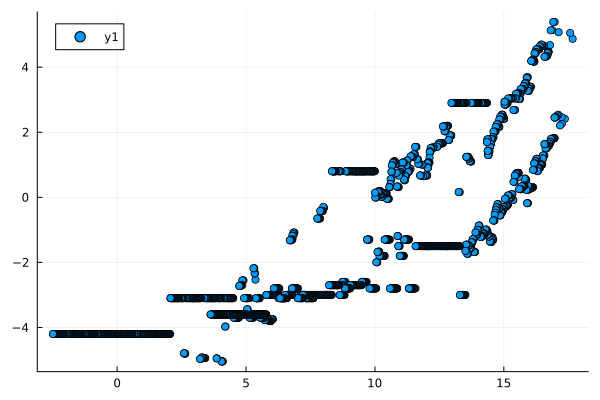

In [64]:
scaled_gedf = scale_coordinates(gedf)

xs = scaled_gedf.latitude;
ys = scaled_gedf.altitude;

scatter(xs, ys)

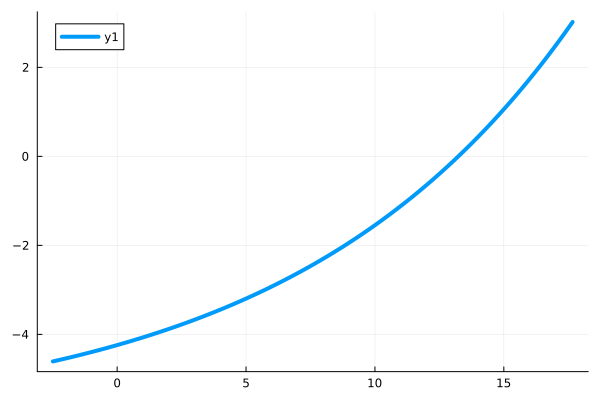

In [65]:
test_x = collect(range(minimum(xs), maximum(xs), length(xs)));

ft = ridge_regression_expo(xs, ys, test_x, 1.0)

# scatter(xs, ys)
plot(ft.latitude, ft.altitude, lw=4)

In [66]:
find_best_lambdas(ridge_regression_expo, [xs, ys, test_x], ys; eval_size=100)

5-element Vector{Any}:
 (lambda = 100.0, rmse = 3.9792712901091245)
 (lambda = 99.0, rmse = 3.979300347955401)
 (lambda = 98.0, rmse = 3.979329407030736)
 (lambda = 97.0, rmse = 3.9793584673352087)
 (lambda = 96.0, rmse = 3.9793875288689002)

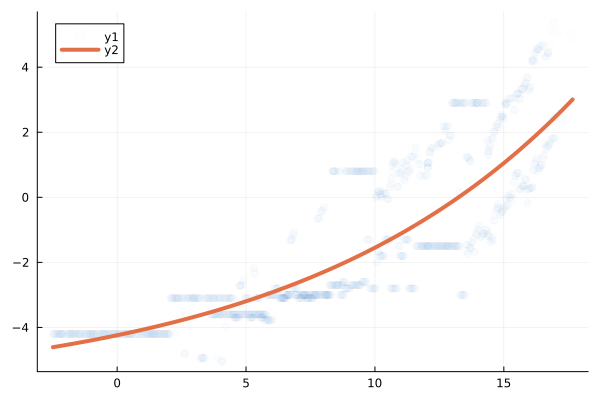

In [67]:
ft = ridge_regression_expo(xs, ys, test_x, 100.)
scatter(xs, ys, ma=0.01)
plot!(ft.latitude, ft.altitude, lw=4)


$y = ae^{kx}$

$ln(y) = ln(a) + kx$

look at the objective instead of rmse

||y -Xc|| - \lambda ||c||2

Fix lam, optim c
Fix c, optim lam

In [69]:
xs = collect(0:0.5:20)
ys = tanh.(xs) + randn(length(xs)) / 25

rdm(xs) = xs^2
rdm2(xs) = sin(xs)
rdm3(xs) = cos(xs) + sin(xs)

M = @. [rdm(xs)^0 rdm(xs) rdm2(xs) rdm3(xs)]

results = []

for i in 1:size(M, 2)
     A = M[:, i]
     X = A \ ys
     push!(results, X)
end

results

4-element Vector{Any}:
 0.9522589515239765
 0.004040053398328748
 0.07210412870359845
 0.05548219852466797

In [70]:
# scatter(xs, ys)


In [71]:
s = Polynomial(results[2])

Polynomial(0.004040053398328748)

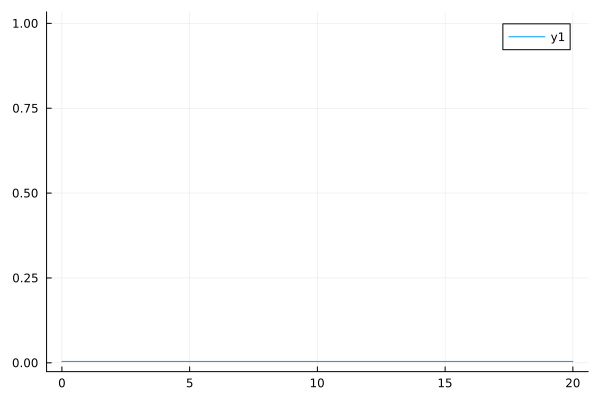

In [72]:
plot(xs, s.(xs))

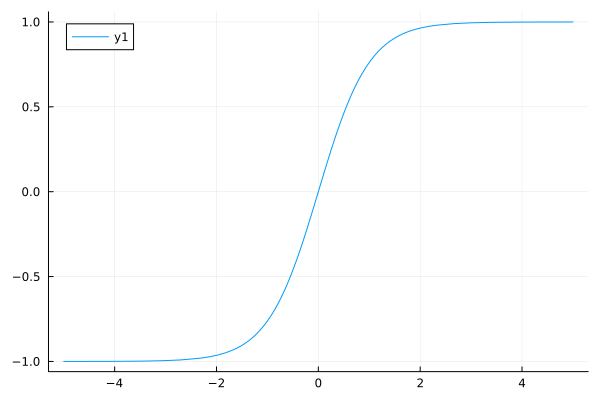

In [74]:
plot(tanh)

In [75]:
function ridge_regression_tanh(xs, ys, test_x, λ)
     
     # taking atanh(y) requires |y| <= 1

     Ymin = minimum(ys)
     Ymax = maximum(ys)
     ϵ = 1e-5

     #scale data to between -1 and 1
     ys′ = 2*((ys .- Ymin) ./ (Ymax - Ymin)) .- 1
     ys′ = clamp.(ys′, -1 + ϵ, 1 - ϵ)
     # @show ys′
     
     Y = atanh.(ys′)

     # design matrix
     X = hcat(ones(length(xs)), xs)

     # regularization matrix
     L = λ * I(size(X, 2))
     L[1, 1] = 0

     # ridge reg. 
     θ = (X' * X + L) \ (X' * Y)

     @show θ

     # Predict on new data
     atanh_y_pred = @. θ[1] + θ[2] .* test_x

     # reverse operation
     y_pred_unscaled = tanh.(atanh_y_pred)
     
     # unscale data
     y_pred = ((y_pred_unscaled .+ 1) ./ 2) .* (Ymax - Ymin) .+ Ymin

     # package up into easy to use form 
     temp = DataFrame(latitude=test_x, altitude=y_pred)
     sort!(temp, :latitude)

     return temp

end

ridge_regression_tanh (generic function with 1 method)

In [76]:
swdf = scale_coordinates(stack_df_vectors(all_dfs["Sweetwater"]))

2526×12 DataFrame
  Row │ time                 seconds_elapsed  bearingAccuracy  speedAccuracy   ⋯
      │ Int64                Float64          Float64          Float64         ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 1712266854188000000          0.755            45.0          1.5        ⋯
    2 │ 1712266855367640000          1.93464          49.5444       0.778974
    3 │ 1712266856366407200          2.93341          69.841        1.44903
    4 │ 1712266857366600000          3.9336           73.7154       1.35204
    5 │ 1712266858367190800          4.93419          11.7684       0.700928   ⋯
    6 │ 1712266859366409700          5.93341          52.3302       1.18339
    7 │ 1712266860366214400          6.93321          45.0          1.5
    8 │ 1712266860698761000          7.26576          45.0          1.5
  ⋮   │          ⋮                  ⋮                ⋮               ⋮         ⋱
 2520 │ 1712673134946047500        362.404            45.0          0.223924   ⋯
 2521 │ 1712673134948178000        362.406            45.0          0.211237
 2522 │ 1712673135949454600        363.407            45.0          0.214629
 2523 │ 1712673136157470000        363.615            45.0          0.21691
 2524 │ 1712673136290079000        363.748            45.0          0.221792   ⋯
 2525 │ 1712673136946444000        364.404            45.0          0.233285
 2526 │ 1712673137948894700        365.407            45.0          0.241509
                                                 8 columns and 2511 rows omitted

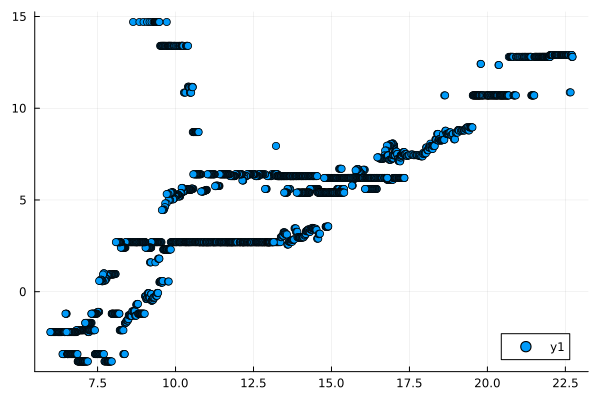

In [77]:
scatter(swdf.latitude, swdf.altitude)

In [78]:
xs = swdf.latitude;
ys = swdf.altitude;

test_x = collect(range(minimum(xs), maximum(xs), length(xs)));

ft = ridge_regression_tanh(xs, ys, test_x, 1.0);

θ = [-1.782279023537966, 0.126403203733717]


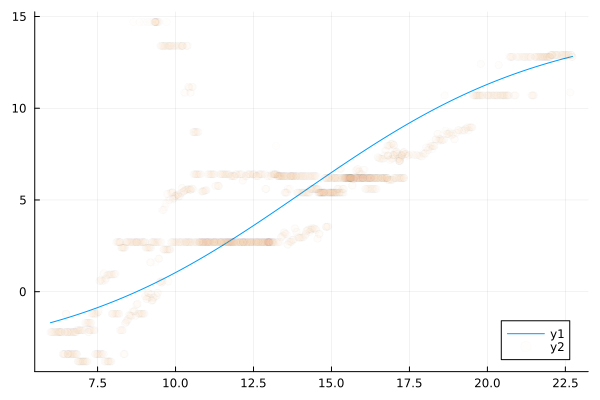

In [80]:
plot(ft.latitude, ft.altitude)
scatter!(xs, ys, ma=0.01)